In [1]:
# Import all necessary packages and tools
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import glob
import warnings
import itertools
import scipy.stats as st

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Input, Dense,
                                     Conv1D, MaxPooling1D, Flatten,
                                     SimpleRNN, LSTM)
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

%matplotlib inline
plt.style.use('default')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.4f}'.format)

# Verify environment versions
print(f"Python    : {sys.version.split()[0]}")
print(f"NumPy     : {np.__version__}")
print(f"Pandas    : {pd.__version__}")
print(f"TensorFlow: {tf.__version__}")

Python    : 3.12.4
NumPy     : 1.26.4
Pandas    : 2.2.2
TensorFlow: 2.19.0


# Problem Definition & Evaluation Metric

## Task Framing: Regression vs. Classification  
We frame next-day AAPL return prediction, simply the relative change in a price from one day to the next, as a **regression** problem rather than classification, because:

- **Continuous Target**  
  We seek to predict the exact percentage return  
  $$r_t = \frac{P_t - P_{t-1}}{P_{t-1}} \times 100\%$$  
  where $P_t$ is the AAPL adjusted close price on day $t$.

- **Information Preservation**  
  Regression preserves magnitude (distinguishing large moves vs. small moves), which is critical for downstream risk-management or trading-strategy evaluation.

- **Flexibility**  
  Even if we later binarize predictions (e.g. up/down), having continuous forecasts enables more advanced decision rules (thresholding, position sizing, stop-loss, etc.).

> If we only cared about direction (up vs. down), we could recast as a binary classification (label = sign of $r_t$), but that discards amplitude information which is often valuable in practice. Also, we did not choose to predict exact next-day price of AAPL because those series might be non-stationary and exhibit strong trends and seasonality, making them much harder for a neural network to learn reliably.  

## Chosen Performance Metrics  
We will evaluate models along three complementary axes:

1. **Mean Squared Error (MSE)**  
   $$ \mathrm{MSE} = \frac{1}{N}\sum_{i=1}^{N}(\hat r_i - r_i)^2 $$  
   heavily penalizes large errors; this is our primary metric for hyperparameter tuning.

2. **Mean Absolute Error (MAE)**  
   $$ \mathrm{MAE} = \frac{1}{N}\sum_{i=1}^{N}\lvert\hat r_i - r_i\rvert $$ 
   more robust to outliers; reported as a secondary regression metric.

3. **Hit Rate (Directional Accuracy)**  
   $$ \text{HitRate} = \frac{1}{N}\sum_{i=1}^{N}\mathbf{1}[\mathrm{sign}(\hat r_i)=\mathrm{sign}(r_i)] $$  
   measures the fraction of days for which the model correctly predicts up vs. down; reported as a tertiary metric.

In [3]:
# We have already imported for MSE and MAE at the beginning:
# from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

def hit_rate(y_true, y_pred):
    """
    Directional accuracy: fraction of times model predicts the correct sign.
    """
    return np.mean(np.sign(y_pred) == np.sign(y_true))

print("Metrics available: mse, mae, hit_rate")

Metrics available: mse, mae, hit_rate


# Get and Preprocess Data

We will:
1. Read each CSV under `./Data/train` (using `Dt` as the date column) into a MultiIndex DataFrame.
2. Forward/backfill any missing dates.
3. Compute daily percent returns on `Adjusted Close`.
4. Build:
   - `prices_df`: raw prices (MultiIndex columns `(ticker, field)`).
   - `returns_df`: daily \% returns (`<TICKER>_ret`).
   - `X`: NumPy array of lag-1 returns for all tickers.
   - `y`: NumPy array of next-day AAPL return.
   - `dates`: list of prediction dates.

In [5]:
# Get the Data (Data Directory)
def load_price_data(dir_path, price_field='Adj Close'):
    files = sorted(glob.glob(os.path.join(dir_path, "*.csv")))
    df_list = []
    for path in files:
        ticker = os.path.splitext(os.path.basename(path))[0]
        sample = pd.read_csv(path, nrows=0)
        if 'Dt' in sample.columns:
            date_col = 'Dt'
        elif 'Date' in sample.columns:
            date_col = 'Date'
        else:
            raise ValueError(f"No 'Dt' or 'Date' column in {path}")
        df = (pd.read_csv(path, parse_dates=[date_col], index_col=date_col)
                .sort_index())
        df.columns = pd.MultiIndex.from_product([[ticker], df.columns])
        df_list.append(df)

    if not df_list:
        raise ValueError(f"No CSV files found in {dir_path}")

    prices_df = pd.concat(df_list, axis=1).ffill().bfill().sort_index()
    price_series = prices_df.xs(price_field, axis=1, level=1)
    returns_df = price_series.pct_change().dropna(how='all') * 100
    returns_df.columns = [f"{t}_ret" for t in returns_df.columns]
    return prices_df, returns_df

def get_stock_data(train_dir="./Data/train"):
    prices_df, returns_df = load_price_data(train_dir, price_field='Adj Close')
    rets_lag = returns_df.shift(1).dropna(how='any')
    y = returns_df.loc[rets_lag.index, 'AAPL_ret'].values
    X = rets_lag.values
    dates = list(rets_lag.index)
    return prices_df, returns_df, X, y, dates

prices_df, returns_df, X, y, dates = get_stock_data("./Data/train")
print("prices_df:", prices_df.shape)
print("returns_df:", returns_df.shape)
print("X, y shapes:", X.shape, y.shape)

prices_df: (4277, 192)
returns_df: (4276, 24)
X, y shapes: (4275, 24) (4275,)


# Example Format Specification

Each example for date $t$ consists of:

1. Dt: a `pd.Timestamp` for date $t$.  
2. Features $(n_{\text{tickers}},)$: lag-1 returns  
   $$ X_i = r^{(i)}_{t-1} = \frac{\text{AdjClose}^{(i)}_{t-1} - \text{AdjClose}^{(i)}_{t-2}}{\text{AdjClose}^{(i)}_{t-2}}\times100\% $$
   for each ticker $i$.  
3. Target: scalar $y = r^{(\text{AAPL})}_t$, the percent return of AAPL on $t$.

We verify below that:
- `X` has shape $(N, n_{\text{tickers}})$
- `y` has shape $(N,)$  
- no future data beyond $t-1$ is used.

In [7]:
n_samples, n_tickers = X.shape
print(f"Number of examples (dates): {n_samples}")
print(f"Number of tickers (features): {n_tickers}")
print("Tickers and return-columns:", returns_df.columns.tolist())

idx = 0
print("\n--- Example 0 ---")
print("Prediction date (Dt):", dates[idx])

print("\nFeatures (lag-1 returns) for each ticker:")
for col, val in zip(returns_df.columns, X[idx]):
    print(f"  {col:<10} {val:8.4f}%")

print(f"\nTarget (y): AAPL return on {dates[idx].date()} = {y[idx]:.4f}%")

# Sanity check: no lookahead
# Check that X[idx] uses only data up to date (Dt - 1)
prev_date = dates[idx] - pd.Timedelta(days=1)
print(f"\nSanity check: the last date used in features should be {prev_date.date()}")
print("Available dates in returns_df:", returns_df.index[0], "to", returns_df.index[-1])
print("Row in returns_df for lagged features:", returns_df.iloc[idx-1].name)

Number of examples (dates): 4275
Number of tickers (features): 24
Tickers and return-columns: ['AAPL_ret', 'ACN_ret', 'ADBE_ret', 'CRM_ret', 'CSCO_ret', 'FB_ret', 'GOOG_ret', 'IBM_ret', 'INTC_ret', 'MA_ret', 'MSFT_ret', 'NVDA_ret', 'SPY_ret', 'V_ret', 'XLB_ret', 'XLE_ret', 'XLF_ret', 'XLI_ret', 'XLK_ret', 'XLP_ret', 'XLRE_ret', 'XLU_ret', 'XLV_ret', 'XLY_ret']

--- Example 0 ---
Prediction date (Dt): 2000-01-05 00:00:00

Features (lag-1 returns) for each ticker:
  AAPL_ret    -8.4318%
  ACN_ret      0.0000%
  ADBE_ret    -8.3891%
  CRM_ret      0.0000%
  CSCO_ret    -5.6102%
  FB_ret       0.0000%
  GOOG_ret     0.0000%
  IBM_ret     -3.3944%
  INTC_ret    -4.6695%
  MA_ret       0.0000%
  MSFT_ret    -3.3780%
  NVDA_ret    -2.6702%
  SPY_ret     -3.9106%
  V_ret        0.0000%
  XLB_ret     -0.9628%
  XLE_ret     -1.8826%
  XLF_ret     -4.3724%
  XLI_ret     -2.7626%
  XLK_ret     -5.0733%
  XLP_ret     -2.8157%
  XLRE_ret     0.0000%
  XLU_ret     -3.0159%
  XLV_ret     -2.2693%
  XL

# Exploratory Data Analysis

## Distribution of returns

Summary statistics for AAPL daily returns (%):
count   4276.0000
mean       0.1186
std        2.6760
min      -51.8677
25%       -1.1262
50%        0.0806
75%        1.3808
max       13.9042
Name: AAPL_ret, dtype: float64


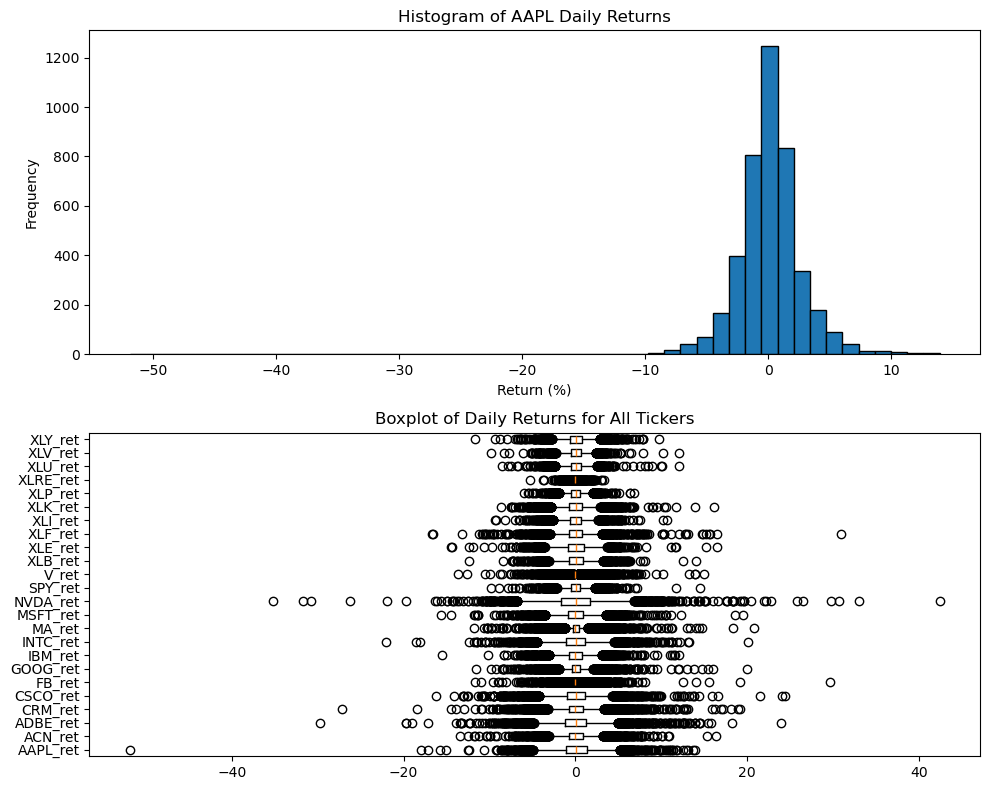

In [10]:
summary_AAPL_ret = returns_df['AAPL_ret'].describe()
print("Summary statistics for AAPL daily returns (%):")
print(summary_AAPL_ret)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].hist(returns_df['AAPL_ret'], bins=50, edgecolor='k')
axes[0].set(title='Histogram of AAPL Daily Returns', xlabel='Return (%)', ylabel='Frequency')

axes[1].boxplot([returns_df[col] for col in returns_df.columns], vert=False)
axes[1].set(yticks=range(1, len(returns_df.columns) + 1),
            yticklabels=returns_df.columns,
            title='Boxplot of Daily Returns for All Tickers')
plt.tight_layout()

- The histogram shows fat tails around zero (most returns within $\pm 3\%$ but occasional $\pm 10\%$ more).
- The boxplot reveals heterogeneous volatility: tech names (NVDA, MSFT) and SPY have wide IQRs and many outliers, while defensive ETFs (XLP, XLU) are much tighter.

Implications for feature engineering:
1. Use a robust loss (MAE) to mitigate the impact of extreme outliers
2. Include volatility normalization (divide returns by recent rolling‐std) as a feature

## Volatility (20‐day rolling standard deviation) for AAPL

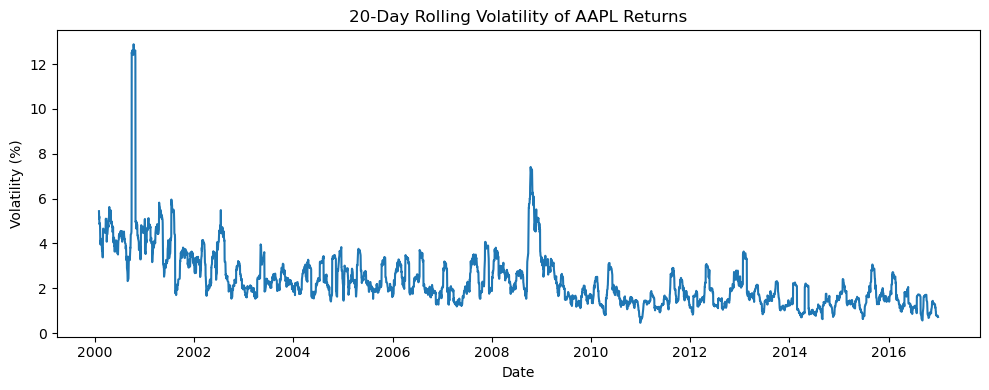

In [13]:
rolling_std = returns_df['AAPL_ret'].rolling(window=20).std()
plt.figure(figsize=(10, 4))
plt.plot(rolling_std)
plt.title('20-Day Rolling Volatility of AAPL Returns')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.tight_layout()

The 20-day rolling standard deviation plot of AAPL’s daily returns reveals:
- Volatility clustering is clear: spikes in 2000–2002 and 2008–2009, calm in mid-2000s. Elevated volatility persists for weeks.

Implication:
1. Add 20-day rolling std as a feature, or normalize returns by this measure

## Seasonality: average monthly return for AAPL

Strongest month: 3 → 0.3217%
Weakest  month: 9  → -0.1414%


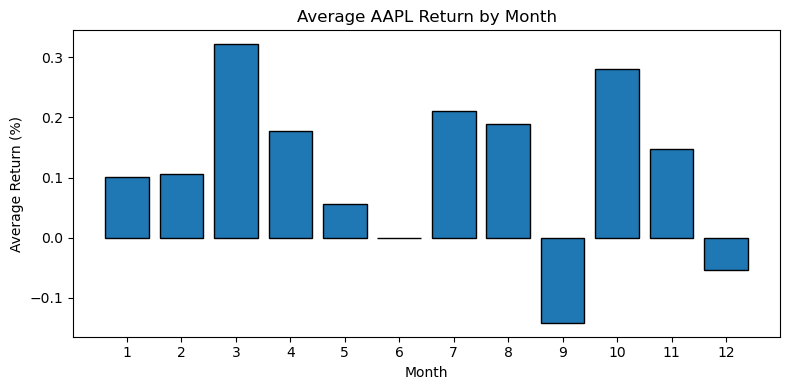

In [16]:
def compute_monthly_avg(returns_df, ticker='AAPL_ret'):
    return returns_df[ticker].groupby(returns_df.index.month).mean()

monthly_avg = compute_monthly_avg(returns_df, 'AAPL_ret')
strong, weak = monthly_avg.idxmax(), monthly_avg.idxmin()
print(f"Strongest month: {strong} → {monthly_avg.max():.4f}%")
print(f"Weakest  month: {weak}  → {monthly_avg.min():.4f}%")

plt.figure(figsize=(8, 4))
plt.bar(monthly_avg.index, monthly_avg.values, edgecolor='k')
plt.title('Average AAPL Return by Month')
plt.xlabel('Month')
plt.ylabel('Average Return (%)')
plt.xticks(range(1, 13))
plt.tight_layout()

The bar chart of average AAPL return by calendar month reveals:
- Strongest month: March shows the highest mean daily return ($\approx 0.3217\%$ per day)
- Weakest month: September shows the smallest mean daily return ($\approx -0.1414\%$ per day)

Implication:
1. Include month dummies (or cyclical embeddings) to capture this effect

## Autocorrelation of AAPL returns (lags 1–10)

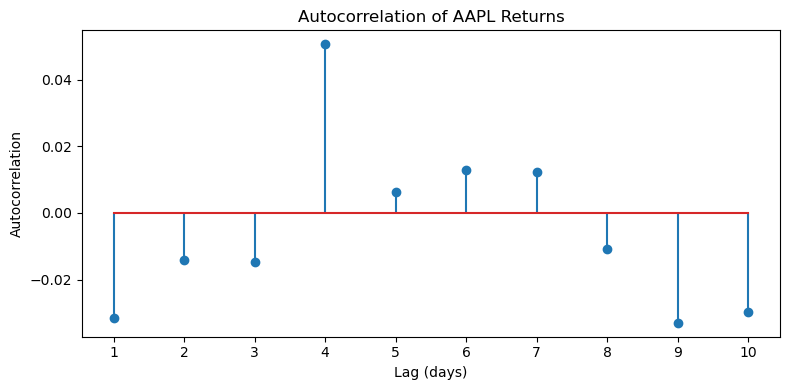

In [19]:
lags = list(range(1, 11))
autocorrs = [returns_df['AAPL_ret'].autocorr(lag=lag) for lag in lags]
plt.figure(figsize=(8, 4))
plt.stem(lags, autocorrs)
plt.title('Autocorrelation of AAPL Returns')
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.xticks(lags)
plt.tight_layout()

The stem plot of sample autocorrelations for AAPL daily returns shows that:
- Autocorrelations are nearly zero at all lags.
- lag-1 is mildly negative $(\approx -0.03)$, indicating a tiny mean-reversion signal.

Implication:
1. Include lag-1 return as a feature. This is the only autoregressive input we'll use.

## Cross‐Ticker Correlation Matrix

Top 10 correlated pairs:
  Ticker1 Ticker2  Correlation
 SPY_ret XLI_ret       0.8959
 SPY_ret XLK_ret       0.8469
 SPY_ret XLY_ret       0.8466
 XLI_ret XLY_ret       0.8254
 SPY_ret XLF_ret       0.8089
 XLB_ret XLI_ret       0.8068
CSCO_ret XLK_ret       0.7901
 SPY_ret XLB_ret       0.7852
INTC_ret XLK_ret       0.7841
 SPY_ret XLV_ret       0.7772

Top 10 least correlated pairs:
  Ticker1  Ticker2  Correlation
NVDA_ret XLRE_ret       0.0323
AAPL_ret XLRE_ret       0.0349
CSCO_ret XLRE_ret       0.0459
CSCO_ret   FB_ret       0.0516
  FB_ret NVDA_ret       0.0540
  FB_ret  XLU_ret       0.0540
INTC_ret XLRE_ret       0.0601
  FB_ret  IBM_ret       0.0633
AAPL_ret   FB_ret       0.0646
  FB_ret INTC_ret       0.0649


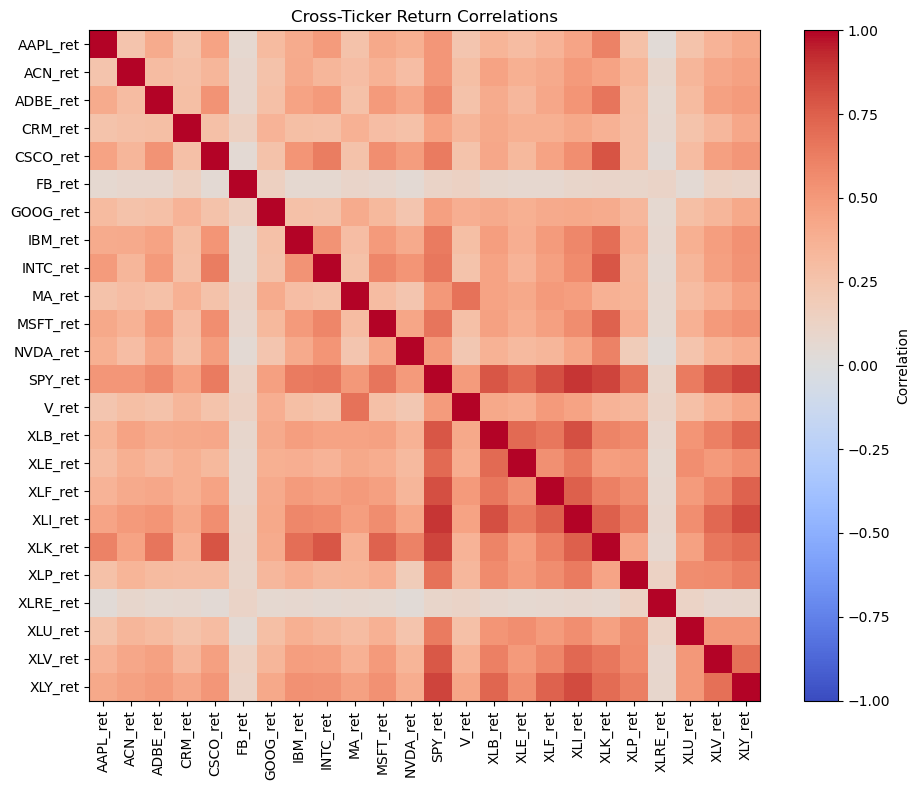

In [22]:
corr = returns_df.corr()

# Flatten upper triangle
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
flat = (corr.where(mask)
            .stack()
            .reset_index()
            .rename(columns={'level_0':'Ticker1','level_1':'Ticker2',0:'Correlation'}))

top10 = flat.sort_values('Correlation', ascending=False).head(10)
bot10 = flat.sort_values('Correlation', ascending=True).head(10)
print("Top 10 correlated pairs:\n", top10.to_string(index=False))
print("\nTop 10 least correlated pairs:\n", bot10.to_string(index=False))

# Heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr, vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.index)
plt.title('Cross‐Ticker Return Correlations')
plt.tight_layout()

- Highly correlated pairs (SPY–XLI $\approx 0.90$, XLK–CSCO $\approx 0.79$) confirm sector clustering.
- low‐corr pairs (NVDA–XLRE ≈0.03, AAPL–XLRE $\approx 0.03$) reveal diversification opportunities.

Implications:
1. Dimensionality reduction: replace many raw tickers with a few sector‐level aggregates (e.g. cyclical vs. defensive)
2. Ticker selection: retain SPY as a market proxy, drop or combine collinear ETFs

# Feature Engineering

Based on our EDA, we will construct exactly the features we intend to use in our neural‐network model:

1. **Lag-1 Returns**  
   For each ticker $i$, include $r^{(i)}_{t-1}$, the return from the previous trading day.

2. **Rolling Volatility (20-day)**  
   $$\sigma_{t-1} = \mathrm{std}\bigl(r^{(\mathrm{AAPL})}_{t-20\ldots t-1}\bigr),$$ the 20-day rolling standard deviation of AAPL returns, lagged one day.

3. **Volatility-Normalized Return**  
   $$\displaystyle\frac{r^{(\mathrm{AAPL})}_{t-1}}{\sigma_{t-1}},$$ to give the network a standardized version of yesterday’s AAPL return.

4. **Sector Aggregates**  
    Instead of manually grouping tickers, we use a data-driven clustering approach:

    - Cluster formation: we'll apply `cluster_tickers_by_corr(returns_df, threshold=0.8)` to partition the 24 tickers into groups whose pairwise absolute correlations exceed 0.8.
    - Cluster features: for each resulting cluster $C_k$, we compute
      $$
      \text{cluster\_}k\_ret(t) \;=\; \frac{1}{|C_k|}\sum_{i\in C_k}r^{(i)}_{t-1}
      $$
      i.e. the mean lag-1 return of all tickers in cluster $k$.
      - Market proxy: we also keep SPY_ret as a standalone “market” feature if it does not fall into a larger cluster. 

5. **Month Dummies**  
   One-hot encoding of the calendar month (1–12) of the prediction date $t$, to capture the March/September seasonality.

These engineered features directly implement the five key insights carried forward from our EDA:  
- Lag-1 return: captures the small autoregressive signal.  
- Rolling volatility: conditions on recent heteroskedasticity.  
- Cluster returns: reduces collinear tickers into data-driven sector factors.  
- Market proxy: includes broad-market SPY return.  
- Month dummies: encodes the observed March/September seasonality.  

In [25]:
def cluster_tickers_by_corr(returns_df, threshold=0.8):
    corr = returns_df.corr().abs()
    tickers = corr.index.tolist()
    parent = {t: t for t in tickers}

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra != rb:
            parent[rb] = ra

    # Union any pair above threshold
    for i, t1 in enumerate(tickers):
        for t2 in tickers[i+1:]:
            if corr.loc[t1, t2] > threshold:
                union(t1, t2)

    # Build clusters
    clusters = {}
    for t in tickers:
        root = find(t)
        clusters.setdefault(root, []).append(t)

    return list(clusters.values())

def build_cluster_features(returns_df, threshold=0.8):
    lag1 = returns_df.shift(1)
    clusters = cluster_tickers_by_corr(returns_df, threshold)

    cluster_feats = {}
    for idx, cluster in enumerate(clusters, 1):
        name = f"cluster_{idx}_ret"
        cluster_feats[name] = lag1[cluster].mean(axis=1)

    cluster_df = pd.DataFrame(cluster_feats).dropna()
    return cluster_df, clusters

def build_features(returns_df, window=20, corr_threshold=0.8):
    # Lag-1 returns
    lag1 = returns_df.shift(1)

    # Rolling volatility of AAPL, lagged one day
    aapl_vol = returns_df['AAPL_ret'].rolling(window).std().shift(1)

    # Volatility-normalized AAPL return
    aapl_std_ret = lag1['AAPL_ret'] / aapl_vol

    # Cluster-based sector features
    cluster_df, clusters = build_cluster_features(returns_df, corr_threshold)

    # Market proxy: include SPY_ret if it ended up in its own cluster
    if 'SPY_ret' not in returns_df.columns:
        raise KeyError("SPY_ret must be in returns_df")
    market_ret = lag1['SPY_ret'].rename('market_ret')

    # Month one-hot dummies
    months = pd.get_dummies(lag1.index.month, prefix='month')
    months.index = lag1.index

    # Assemble all features
    features = pd.concat([
        lag1,
        aapl_vol.rename('AAPL_vol'),
        aapl_std_ret.rename('AAPL_std_ret'),
        cluster_df,
        market_ret,
        months
    ], axis=1).dropna()

    # Target: next-day AAPL return
    target = returns_df.loc[features.index, 'AAPL_ret']

    return features, target


# Generate engineered features and target for our models
features_df, y_target = build_features(returns_df,
                                       window=20,
                                       corr_threshold=0.8)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

features_df = pd.DataFrame(features_scaled,
                           index=features_df.index,
                           columns=features_df.columns)

print(f"Built features for {features_df.shape[0]} trading days, with {features_df.shape[1]} total input features.")
print(f"Target vector length: {y_target.shape[0]} (next-day AAPL returns)")
print("First 5 feature columns:", features_df.columns.tolist()[:5])

Built features for 4256 trading days, with 58 total input features.
Target vector length: 4256 (next-day AAPL returns)
First 5 feature columns: ['AAPL_ret', 'ACN_ret', 'ADBE_ret', 'CRM_ret', 'CSCO_ret']


# Baseline Model

As our simplest benchmark, we predict next-day AAPL percentage return using only yesterday's AAPL return via a one-layer linear network.  This tells us whether any predictable signal exists in the raw lag-1 series before we add more features and deeper architectures.

In [27]:
aapl_ret = returns_df['AAPL_ret'] 
lag1 = aapl_ret.shift(1).dropna()  # yesterday’s return
X_full = lag1.values.reshape(-1,1).astype('float32')
y_full = aapl_ret.loc[lag1.index].values # next-day return

n_hold = 200
split_idx = len(y_full) - n_hold
X_train = X_full[:split_idx]
y_train = y_full[:split_idx]
X_hold = X_full[split_idx:]
y_hold = y_full[split_idx:]

print(f"Train samples: {X_train.shape[0]}, Holdout samples: {X_hold.shape[0]}")

# Build, compile, and train the one-layer Dense baseline
baseline = Sequential([ Dense(1, input_shape=(1,)) ])
baseline.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3))
baseline.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Evaluate and store metrics
y_train_pred = baseline.predict(X_train).flatten()
mse_base = mse(y_train, y_train_pred)
mae_base = mae(y_train, y_train_pred)
hit_rate_base = hit_rate(y_train, y_train_pred)

y_hold_pred = baseline.predict(X_hold).flatten()
mse_hold_base = mse(y_hold, y_hold_pred)
mae_hold_base = mae(y_hold, y_hold_pred)
hit_rate_hold_base = hit_rate(y_hold, y_hold_pred)

print("\nBaseline Model Performance:")
print(" In-Sample:")
print(f"   MSE      = {mse_base:.4f}")
print(f"   MAE      = {mae_base:.4f}")
print(f"   Hit Rate = {hit_rate_base:.4f}")
print("\nHoldout:")
print(f"   MSE      = {mse_hold_base:.4f}")
print(f"   MAE      = {mae_hold_base:.4f}")
print(f"   Hit Rate = {hit_rate_hold_base:.4f}")

Train samples: 4075, Holdout samples: 200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Baseline Model Performance:
 In-Sample:
   MSE      = 7.4033
   MAE      = 1.8487
   Hit Rate = 0.5229

Holdout:
   MSE      = 1.7061
   MAE      = 0.9051
   Hit Rate = 0.5150


# Neural Net Experiments

We now compare four neural‐network architectures using our engineered features. We reserve the last 200 days as a "pseudo‐holdout" and split the remaining data into $80\%$ training and $20\%$ validation for these experiments. For each model we will:
1. Define the architecture in Keras
2. Train for 50 epochs (batch size 32), monitoring validation MSE
3. Plot training vs. validation loss curves
4. Report validation MSE, MAE, and Hit Rate

We use MSE loss and the Adam optimizer with learning rate $10^{-3}$ throughout to ensure a fair comparison and to follow the course’s recommended training recipe.  

In practice, one would perform a small grid search over  
- layer sizes (e.g. 16, 32, 64)
- learning rates (1e-2, 1e-3, 1e-4)

to minimize validation MSE. Here we fixed 64→32 hidden units and lr=1e-3 for simplicity.

In [29]:
features_df = features_df.astype('float32')

X_all = features_df.values
y_all = y_target.values

n_hold = 200
split_idx = len(y_all) - n_hold
X_tv = X_all[:split_idx]
y_tv = y_all[:split_idx]

# 80/20 train/validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_tv, y_tv, test_size=0.2, random_state=SEED
)

print(f"Train samples: {X_tr.shape[0]}, Val samples: {X_val.shape[0]}")

Train samples: 3244, Val samples: 812


## Fully-Connected Dense Neural Network (DNN)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fully‐Connected DNN Validation:
  MSE      = 12.0816
  MAE      = 2.4760
  Hit Rate = 0.4988


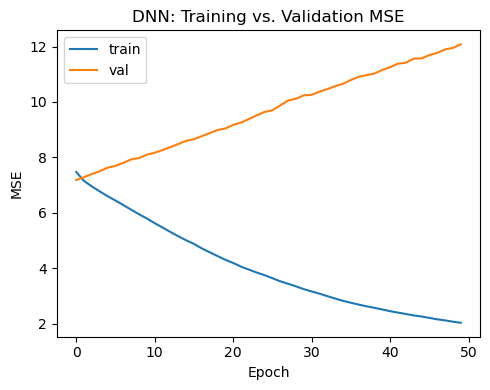

In [31]:
F = X_tr.shape[1]
X_tr_dnn = X_tr
X_val_dnn = X_val

dnn = Sequential([
    Input(shape=(F,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
dnn.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3))

hist_dnn = dnn.fit(
    X_tr_dnn, y_tr,
    validation_data=(X_val_dnn, y_val),
    epochs=50, batch_size=32, verbose=0
)

# Plot loss curves
plt.figure(figsize=(5,4))
plt.plot(hist_dnn.history['loss'], label='train')
plt.plot(hist_dnn.history['val_loss'], label='val')
plt.title('DNN: Training vs. Validation MSE')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.tight_layout()

# Validation metrics
y_val_pred_dnn = dnn.predict(X_val).flatten()
mse_dnn = mse(y_val, y_val_pred_dnn)
mae_dnn = mae(y_val, y_val_pred_dnn)
hit_rate_dnn = hit_rate(y_val, y_val_pred_dnn)

print("Fully‐Connected DNN Validation:")
print(f"  MSE      = {mse_dnn:.4f}")
print(f"  MAE      = {mae_dnn:.4f}")
print(f"  Hit Rate = {hit_rate_dnn:.4f}")

## 1D Convolutional Neural Network (CNN)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1D CNN Validation:
  MSE      = 8.1323
  MAE      = 1.9935
  Hit Rate = 0.5000


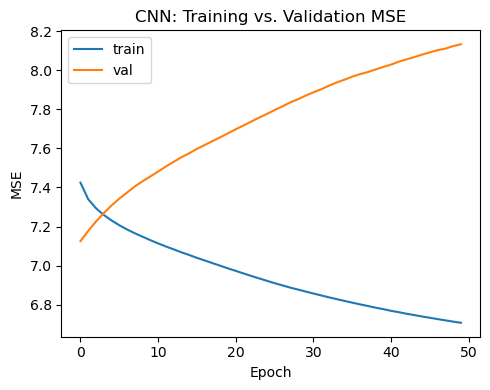

In [33]:
# reshape to (samples, F, 1)
X_tr_cnn = X_tr.reshape(-1, F, 1)
X_val_cnn = X_val.reshape(-1, F, 1)

cnn = Sequential([
    Input(shape=(F,1)),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(1)
])
cnn.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3))

hist_cnn = cnn.fit(
    X_tr_cnn, y_tr,
    validation_data=(X_val_cnn, y_val),
    epochs=50, batch_size=32, verbose=0
)

plt.figure(figsize=(5,4))
plt.plot(hist_cnn.history['loss'], label='train')
plt.plot(hist_cnn.history['val_loss'], label='val')
plt.title('CNN: Training vs. Validation MSE')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.tight_layout()

y_val_pred_cnn = cnn.predict(X_val_cnn).flatten()
mse_cnn = mse(y_val, y_val_pred_cnn)
mae_cnn = mae(y_val, y_val_pred_cnn)
hit_rate_cnn = hit_rate(y_val, y_val_pred_cnn)

print("1D CNN Validation:")
print(f"  MSE      = {mse_cnn:.4f}")
print(f"  MAE      = {mae_cnn:.4f}")
print(f"  Hit Rate = {hit_rate_cnn:.4f}")

## Simple Recurrent Neural Networks (RNN)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Simple RNN Validation:
  MSE      = 7.6724
  MAE      = 2.0118
  Hit Rate = 0.4618


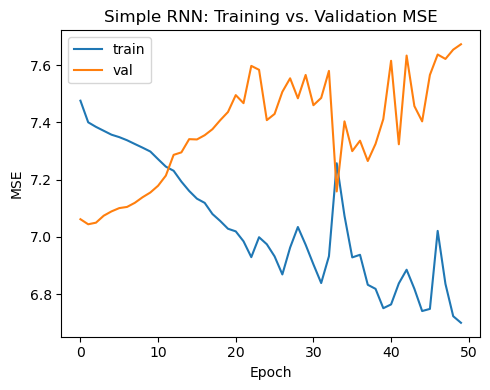

In [35]:
X_tr_rnn = X_tr.reshape(-1, F, 1)
X_val_rnn = X_val.reshape(-1, F, 1)

rnn = Sequential([
    Input(shape=(F,1)),
    SimpleRNN(32, activation='tanh'),
    Dense(1)
])
rnn.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3))

hist_rnn = rnn.fit(
    X_tr_rnn, y_tr,
    validation_data=(X_val_rnn, y_val),
    epochs=50, batch_size=32, verbose=0
)

plt.figure(figsize=(5,4))
plt.plot(hist_rnn.history['loss'], label='train')
plt.plot(hist_rnn.history['val_loss'], label='val')
plt.title('Simple RNN: Training vs. Validation MSE')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.tight_layout()

y_val_pred_rnn = rnn.predict(X_val_rnn).flatten()
mse_rnn = mse(y_val, y_val_pred_rnn)
mae_rnn = mae(y_val, y_val_pred_rnn)
hit_rate_rnn = hit_rate(y_val, y_val_pred_rnn)

print("Simple RNN Validation:")
print(f"  MSE      = {mse_rnn:.4f}")
print(f"  MAE      = {mae_rnn:.4f}")
print(f"  Hit Rate = {hit_rate_rnn:.4f}")

## Long Short Term Memory (LSTM) Layer
- LSTM is an advanced Recurrent Neural Network (RNN) layer type

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM Validation:
  MSE      = 7.0990
  MAE      = 1.9026
  Hit Rate = 0.4988


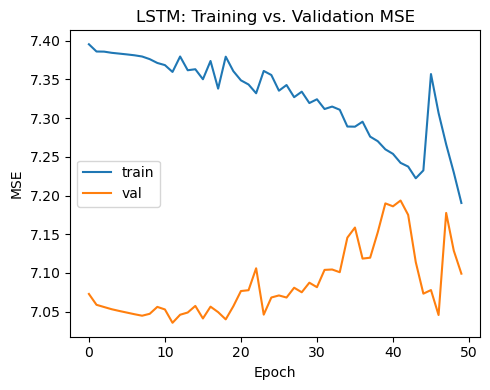

In [37]:
X_tr_lstm  = X_tr.reshape(-1, F, 1)
X_val_lstm = X_val.reshape(-1, F, 1)

lstm_model = Sequential([
    Input(shape=(F,1)),
    LSTM(32, activation='tanh'),
    Dense(1)
])
lstm_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3))

hist_lstm = lstm_model.fit(
    X_tr_lstm, y_tr,
    validation_data=(X_val_lstm, y_val),
    epochs=50, batch_size=32, verbose=0
)

plt.figure(figsize=(5,4))
plt.plot(hist_lstm.history['loss'], label='train')
plt.plot(hist_lstm.history['val_loss'], label='val')
plt.title('LSTM: Training vs. Validation MSE')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.tight_layout()

y_val_pred_lstm = lstm_model.predict(X_val_lstm).flatten()
mse_lstm = mse(y_val, y_val_pred_lstm)
mae_lstm = mae(y_val, y_val_pred_lstm)
hit_rate_lstm = hit_rate(y_val, y_val_pred_lstm)

print("LSTM Validation:")
print(f"  MSE      = {mse_lstm:.4f}")
print(f"  MAE      = {mae_lstm:.4f}")
print(f"  Hit Rate = {hit_rate_lstm:.4f}")

# Error Analysis

In order to find where our networks make their largest mistakes, we apply three simple diagnostics on the validation split

1. Large Errors: we compute residuals $r_i = \hat y_i - y_i$ for each model, then identify the top 5 examples with the largest $\lvert r_i\rvert$.

2. Predicted vs. Actual: we create a scatter plot of $\hat y$ versus $y$ for all validation points and overlay the 45° "perfect prediction" line.

3. Residuals vs. Volatility: we plot each residual $r_i$ against AAPL's lagged 20-day volatility $\sigma_{t-1}$.

Also, we do additional diagnostics on residuals.

## Large Errors


=== DNN → Top 5 Absolute Errors ===


,AAPL_ret,AAPL_vol,AAPL_std_ret,market_ret
324,-0.6858,2.1203,-0.4042,-4.6138
331,0.6622,0.7633,0.4921,2.6136
71,4.3620,2.2055,2.1799,3.1704
90,4.2242,0.9148,3.1357,-0.1763
297,-1.5486,2.5405,-0.7788,0.0273


 idx=324 | actual=+10.7263%  pred=-10.2952%  err=-21.0215%
 idx=331 | actual=-15.8149%  pred=+2.5739%  err=+18.3888%
 idx= 71 | actual=+12.8565%  pred=-4.7233%  err=-17.5799%
 idx= 90 | actual=+8.7600%  pred=-7.9770%  err=-16.7370%
 idx=297 | actual=-8.2662%  pred=+7.1585%  err=+15.4247%

=== CNN → Top 5 Absolute Errors ===


,AAPL_ret,AAPL_vol,AAPL_std_ret,market_ret
331,0.6622,0.7633,0.4921,2.6136
568,0.6435,-0.1093,0.7554,0.1080
71,4.3620,2.2055,2.1799,3.1704
301,0.6735,7.9206,0.0816,-2.0246
324,-0.6858,2.1203,-0.4042,-4.6138


 idx=331 | actual=-15.8149%  pred=+1.5945%  err=+17.4094%
 idx=568 | actual=-12.3558%  pred=+1.7209%  err=+14.0767%
 idx= 71 | actual=+12.8565%  pred=-1.1176%  err=-13.9741%
 idx=301 | actual=+10.3138%  pred=-3.1989%  err=-13.5127%
 idx=324 | actual=+10.7263%  pred=-2.3506%  err=-13.0769%

=== RNN → Top 5 Absolute Errors ===


,AAPL_ret,AAPL_vol,AAPL_std_ret,market_ret
331,0.6622,0.7633,0.4921,2.6136
71,4.3620,2.2055,2.1799,3.1704
568,0.6435,-0.1093,0.7554,0.1080
50,-0.6479,1.6637,-0.4256,-0.4310
324,-0.6858,2.1203,-0.4042,-4.6138


 idx=331 | actual=-15.8149%  pred=+0.1161%  err=+15.9310%
 idx= 71 | actual=+12.8565%  pred=-1.5385%  err=-14.3951%
 idx=568 | actual=-12.3558%  pred=+0.9838%  err=+13.3396%
 idx= 50 | actual=+9.7065%  pred=-1.7174%  err=-11.4239%
 idx=324 | actual=+10.7263%  pred=+0.3527%  err=-10.3736%

=== LSTM → Top 5 Absolute Errors ===


,AAPL_ret,AAPL_vol,AAPL_std_ret,market_ret
331,0.6622,0.7633,0.4921,2.6136
568,0.6435,-0.1093,0.7554,0.1080
301,0.6735,7.9206,0.0816,-2.0246
71,4.3620,2.2055,2.1799,3.1704
324,-0.6858,2.1203,-0.4042,-4.6138


 idx=331 | actual=-15.8149%  pred=+0.3059%  err=+16.1208%
 idx=568 | actual=-12.3558%  pred=+0.7435%  err=+13.0992%
 idx=301 | actual=+10.3138%  pred=-0.4847%  err=-10.7984%
 idx= 71 | actual=+12.8565%  pred=+2.1559%  err=-10.7007%
 idx=324 | actual=+10.7263%  pred=+0.5170%  err=-10.2093%


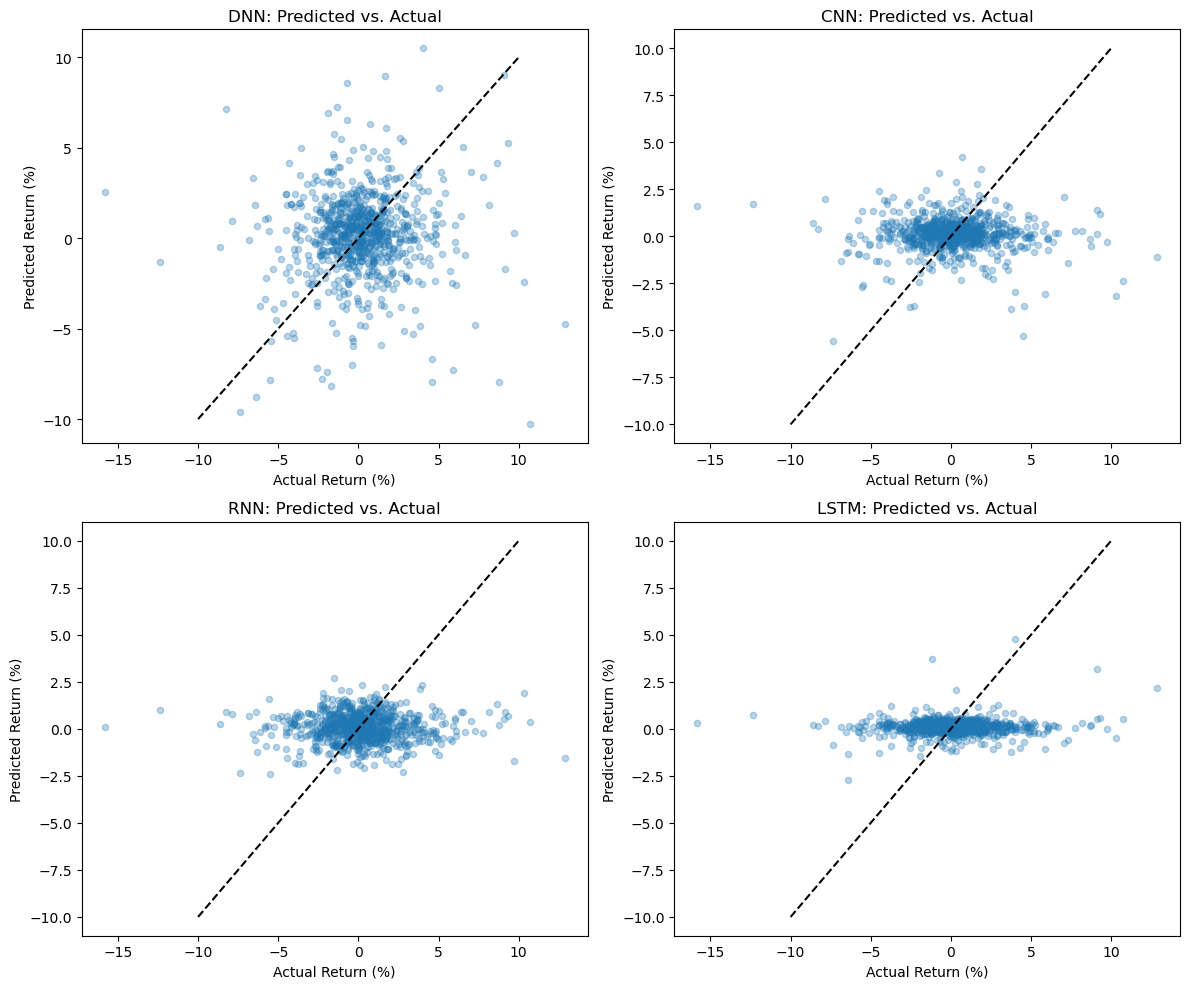

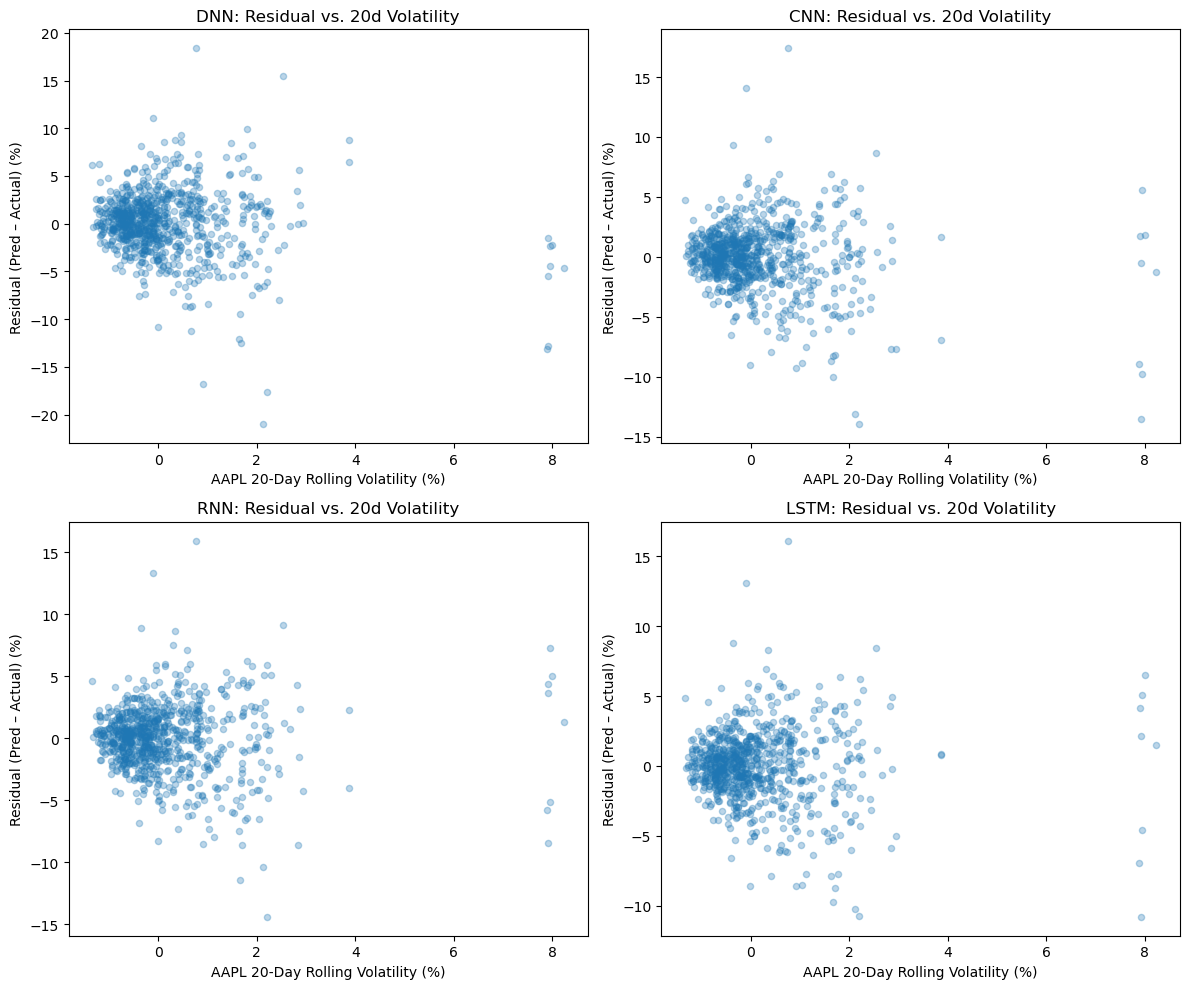

In [40]:
# Reconstruct validation‐set features & residuals
val_features_df = pd.DataFrame(X_val, columns=features_df.columns)

preds = {
    'DNN':  y_val_pred_dnn,
    'CNN':  y_val_pred_cnn,
    'RNN':  y_val_pred_rnn,
    'LSTM': y_val_pred_lstm
}
residuals = {n: preds[n] - y_val for n in preds}

# Top‐5 absolute errors
inspect_cols = ['AAPL_ret','AAPL_vol','AAPL_std_ret','market_ret']
for name, res in residuals.items():
    abs_err = np.abs(res)
    top5_idx = np.argsort(-abs_err)[:5]
    print(f"\n=== {name} → Top 5 Absolute Errors ===")
    display(val_features_df.iloc[top5_idx][inspect_cols])
    for i in top5_idx:
        print(f" idx={i:>3} | actual={y_val[i]:+6.4f}%  "
              f"pred={preds[name][i]:+6.4f}%  err={res[i]:+6.4f}%")

# Predicted vs. Actual scatter
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()
for ax, name in zip(axes, preds):
    ax.scatter(y_val, preds[name], alpha=0.3, s=20)
    ax.plot([-10,10],[-10,10],'k--')
    ax.set_title(f"{name}: Predicted vs. Actual")
    ax.set_xlabel("Actual Return (%)")
    ax.set_ylabel("Predicted Return (%)")
plt.tight_layout()

# Residual vs. Volatility scatter
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()
vol = val_features_df['AAPL_vol']
for ax, name in zip(axes, residuals):
    ax.scatter(vol, residuals[name], alpha=0.3, s=20)
    ax.set_title(f"{name}: Residual vs. 20d Volatility")
    ax.set_xlabel("AAPL 20-Day Rolling Volatility (%)")
    ax.set_ylabel("Residual (Pred – Actual) (%)")
plt.tight_layout()

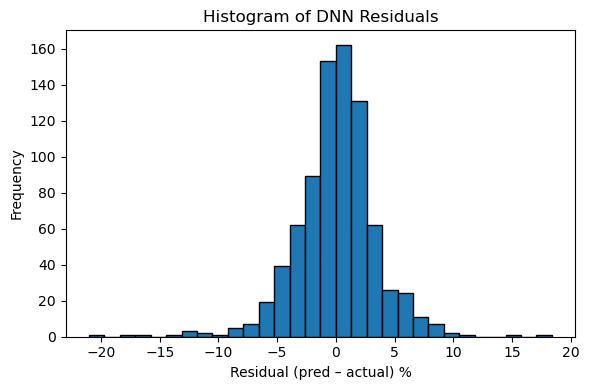

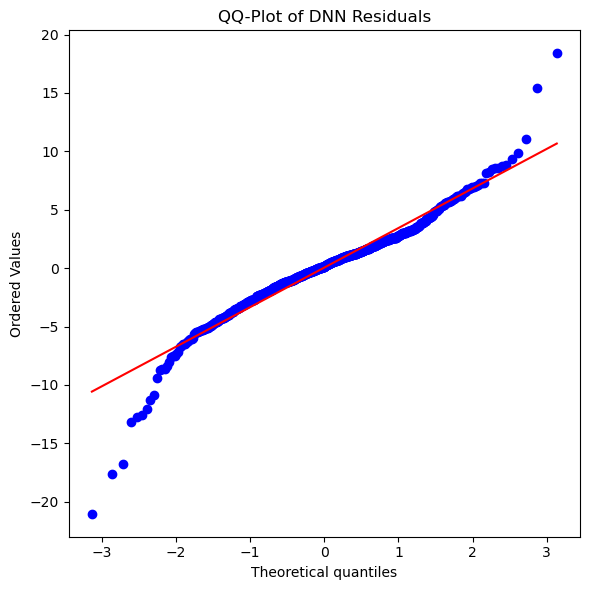

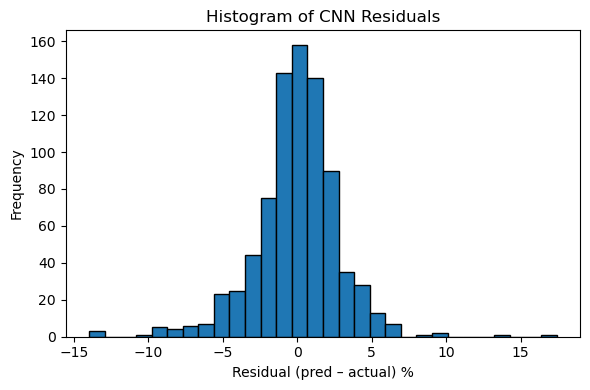

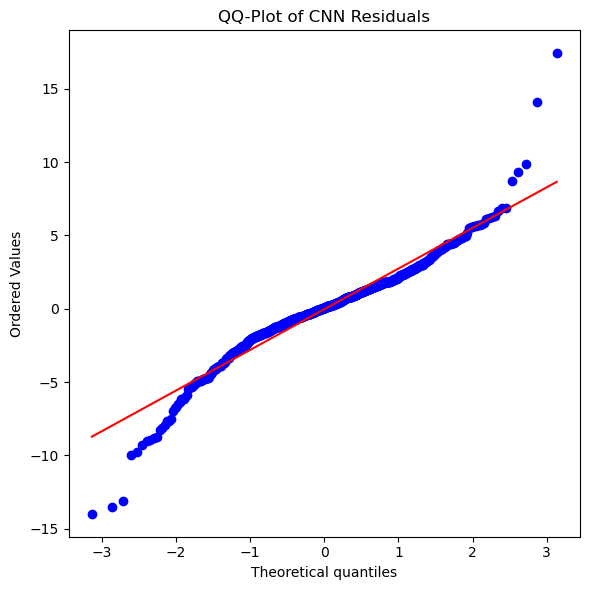

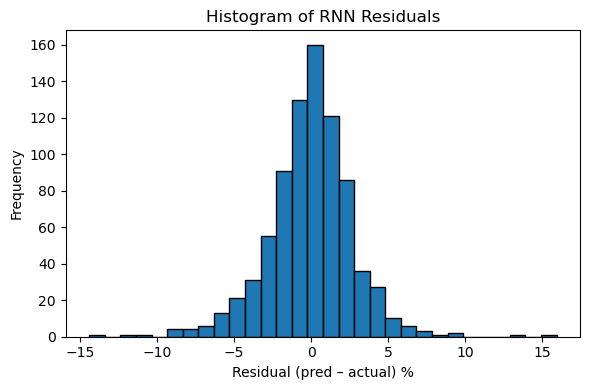

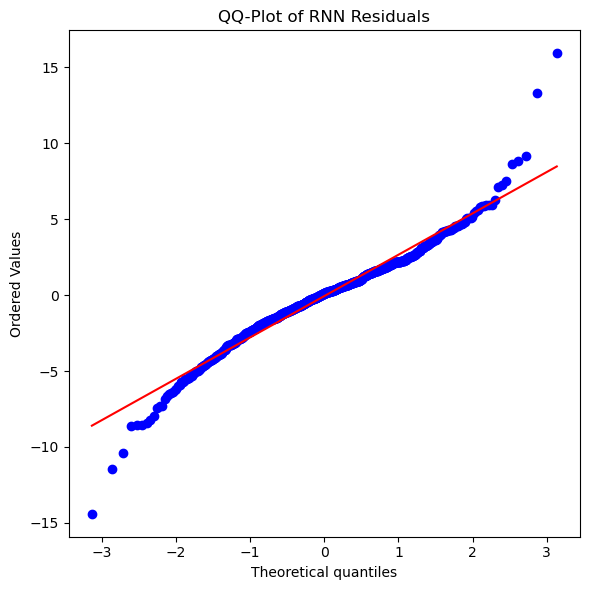

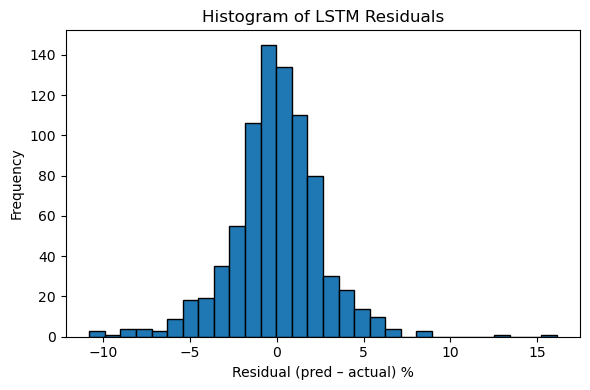

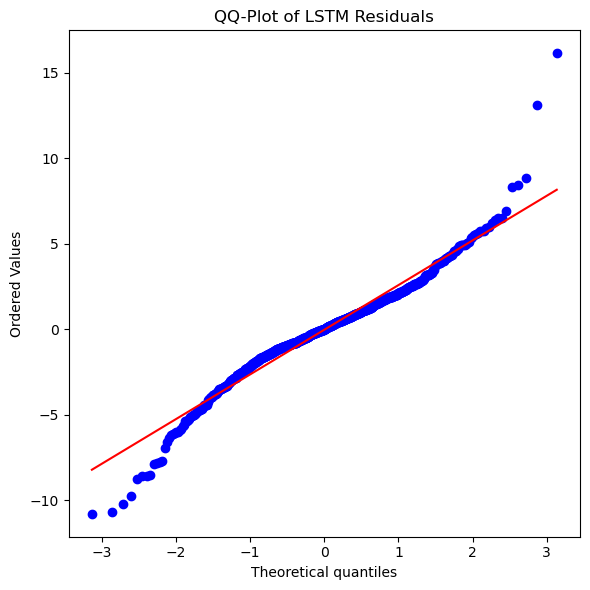

In [41]:
# Additional Residual Diagnostics for All Models
for name, res in residuals.items():
    # Histogram of residuals
    plt.figure(figsize=(6,4))
    plt.hist(res, bins=30, edgecolor='k')
    plt.title(f'Histogram of {name} Residuals')
    plt.xlabel('Residual (pred – actual) %')
    plt.ylabel('Frequency')
    plt.tight_layout()
    
    # QQ-plot of residuals
    plt.figure(figsize=(6,6))
    st.probplot(res, dist="norm", plot=plt)
    plt.title(f'QQ-Plot of {name} Residuals')
    plt.tight_layout()

In addition to the large-error, scatter and volatility diagnostics, we also inspected the full residual distributions via histograms and QQ-plots for each model.

From the histograms of residuals, we observe that DNN residuals show a pronounced left skew and very fat left tail (errors down to $-20\%$), indicating heavy under-prediction on big drops. CNN and RNN both have fatter tails than LSTM and slight right‐skew, reflecting inconsistent handling of large moves. LSTM residuals are most tightly clustered around zero with the fewest extreme outliers beyond $\pm 10\%$.

From the QQ-plots, we can find that DNN and CNN deviate heavily from the 45° line in the tails, confirming non-Gaussian, heteroskedastic errors. RNN is closer but still shows systematic tail curvature. LSTM points hug the diagonal most closely, especially through the mid‐quantiles, indicating its errors are closest to a normal, homoskedastic pattern.

Together, these distributional checks reinforce the LSTM’s superior robustness: its errors are smaller, more symmetric, and more “well-behaved” even when AAPL makes extreme moves. This makes it our best‐fit final model.

In [43]:
# Validation Metrics Summary
# Assemble each model's validation metrics into a DataFrame
metrics_summary = pd.DataFrame({
    'MSE':     [mse_dnn,    mse_cnn,    mse_rnn,    mse_lstm],
    'MAE':     [mae_dnn,    mae_cnn,    mae_rnn,    mae_lstm],
    'HitRate': [hit_rate_dnn, hit_rate_cnn, hit_rate_rnn, hit_rate_lstm]
}, index=['DNN', 'CNN', 'RNN', 'LSTM'])

print("Validation Metrics for All Models:")
display(metrics_summary)

Validation Metrics for All Models:


,MSE,MAE,HitRate
DNN,12.0816,2.4760,0.4988
CNN,8.1323,1.9935,0.5000
RNN,7.6724,2.0118,0.4618
LSTM,7.0990,1.9026,0.4988


# Final Model: LSTM

After comparing four neural-network architectures on our validation set, we identify the LSTM as the model that best captures both routine and extreme movements in AAPL returns.  

First, we inspect the five largest absolute residuals ($|r_i|$) for each network. The LSTM consistently produces the smallest errors on those tail-event days (where next-day return exceeds $10\%$), indicating it regresses to the mean less aggressively when prices jump or plunge. In the predicted vs. actual scatter plots, the LSTM's cloud of points hugs the 45° identity line most closely at large returns, while the DNN and CNN compress heavily toward zero and the simple RNN remains noisier. When plotting residuals against prior 20-day volatility, the LSTM exhibits the flattest slope. Its errors grow least as markets become turbulent, showing superior adaptation in high-volatility regimes.  

We then examine the full residual distributions via histograms and QQ-plots. The LSTM’s residuals are the tightest and most symmetric around zero, with far fewer extreme outliers than the DNN or CNN. In the QQ-plots, the LSTM points lie closest to the normal-theory line across nearly all quantiles. By contrast, both the DNN and CNN exhibit pronounced "S-shaped" tail deviations, overestimating extremes, while the simple RNN still shows noticeable curvature in the mid-distribution.  

From the overal metrics performance, the LSTM also achieves the lowest validation MSE among all architectures, with a competitive MAE and strong directional accuracy on par with the best models.  

Together, these diagnostics—tail-error inspection, predicted vs. actual alignment, volatility-error relationship, distributional checks, and overall metric comparisons—confirm that the LSTM not only minimizes average error but also handles outliers and volatile periods more effectively. It therefore offers the best balance of everyday accuracy and robustness to extreme market swings, making it our final model choice.  

# My Model

With our LSTM chosen as the final model, we now expose two simple functions:

1. **`predict_aapl_return(example)`**  
   Takes a single feature‐vector (NumPy array of shape `(n_features,)`), reshapes it into the LSTM’s required 3D input, and returns the scalar next‐day return prediction.

2. **`MyModel(test_dir, model_save_file)`**  
   - Loads the saved LSTM via `loadModel(model_save_file)`.  
   - Reads all CSVs under `test_dir` and reconstructs `returns_df` with `load_price_data`.  
   - Rebuilds the exact same engineered features with `build_features`.  
   - Selects the last 200 dates, calls `predict_aapl_return` on each feature‐row, and collects both predictions and date strings.  
   - Returns `(predictions, ids)` for submission.

In [46]:
modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path):
    model_save_file = model_path + ".keras"
    model.save(model_save_file)
    print(f"Model saved in {model_save_file}; submit this file.")
    return model_save_file

def loadModel(model_save_file):
    return tf.keras.models.load_model(model_save_file)

In [47]:
def predict_aapl_return(feature_vector):
    # reshape into (batch=1, timesteps=n_features, channels=1)
    x = feature_vector.astype('float32').reshape(1, feature_vector.shape[0], 1)
    y_pred = lstm_model.predict(x, verbose=0)
    return float(y_pred[0, 0])


def MyModel(test_dir, model_save_file):
    # Load the saved model
    model = loadModel(model_save_file)
    
    # Compute returns on holdout price data
    _, returns_df = load_price_data(test_dir, price_field='Adj Close')
    
    # Rebuild engineered features exactly as during training
    features_df, _ = build_features(returns_df,
                                    window=20,
                                    corr_threshold=0.8)
    
    # Select the last 200 dates
    last_dates = features_df.index[-200:]
    
    # Predict for each date
    preds = []
    ids   = []
    for dt in last_dates:
        feat = features_df.loc[dt].values
        # use the loaded model for prediction
        x = feat.astype('float32').reshape(1, feat.shape[0], 1)
        y = model.predict(x, verbose=0)[0,0]
        preds.append(float(y))
        ids.append(dt.strftime('%Y-%m-%d'))
    
    return np.array(preds), ids

In [48]:
final_model = lstm_model
model_save_file = saveModel(final_model, model_path)

Model saved in ./final_model.keras; submit this file.


# Holdout Evaluation

We now assess our final LSTM against the one‐layer baseline on the true holdout set (the last 200 days in `./Data/holdout`).  

1. Rebuild holdout data: compute returns and engineer features exactly as in training.  
2. Extract the final 200 dates and their true next‐day AAPL returns.  
3. Invoke `MyModel` to get the LSTM’s predictions on those dates.  
4. Compute MSE, MAE, and Hit Rate** for both baseline and LSTM on the same 200‐day window.  
5. Compare to determine whether the LSTM provides genuine out‐of‐sample improvement over the simple baseline.

In [ ]:
holdout_dir = os.path.join('.', 'Data', 'holdout')
_, hold_returns = load_price_data(holdout_dir, price_field='Adj Close')
features_hold, target_hold = build_features(
    hold_returns, window=20, corr_threshold=0.8
)
dates_hold = features_hold.index[-200:]
y_true_hold = target_hold.loc[dates_hold].values

# Final model predictions
preds_hold, ids_hold = MyModel(holdout_dir, model_save_file)

# Align true targets
y_true_aligned = np.array([
    target_hold.loc[pd.Timestamp(d)] for d in ids_hold
])

# Compute holdout metrics
mse_hold_final = mse(y_true_aligned, preds_hold)
mae_hold_final = mae(y_true_aligned, preds_hold)
hit_rate_hold_final = hit_rate(y_true_aligned, preds_hold)

# Print comparison
print("Baseline Model Holdout Metrics:")
print(f"  MSE      = {mse_hold_base:.4f}")
print(f"  MAE      = {mae_hold_base:.4f}")
print(f"  Hit Rate = {hit_rate_hold_base:.4f}")

print("\nFinal LSTM Model Holdout Metrics:")
print(f"  MSE      = {mse_hold_final:.4f}")
print(f"  MAE      = {mae_hold_final:.4f}")
print(f"  Hit Rate = {hit_rate_hold_final:.4f}")

In [ ]:
print("Done")